# Analysis

**Hypothesis**: In severe COVID-19, NK cells exhibit a disrupted coupling between metabolic stress and protein synthesis. Specifically, we hypothesize that in COVID patients the correlation between mitochondrial content (percent_mt) and ribosomal protein expression (percent_rpl and percent_rps) in NK cells is altered compared to healthy individuals, indicating metabolic dysregulation that may impact NK cell function.

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/scratch/users/salber/Single_cell_atlas_of_peripheral_immune_response_to_SARS_CoV_2_infection.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


# Analysis Plan

**Hypothesis**: In severe COVID-19, NK cells exhibit a disrupted coupling between metabolic stress and protein synthesis. Specifically, we hypothesize that in COVID patients the correlation between mitochondrial content (percent_mt) and ribosomal protein expression (percent_rpl and percent_rps) in NK cells is altered compared to healthy individuals, indicating metabolic dysregulation that may impact NK cell function.

## Steps:
- Subset the anndata object to only include NK cells based on the 'cell_type_coarse' annotation. Include an assertion to ensure that required columns are present.
- Divide the NK cell subset into two groups based on the 'Status' metadata: one for COVID patients and one for healthy controls.
- Assess the linearity of the relationships between percent_mt and percent_rpl as well as between percent_mt and percent_rps using scatter plots or simple regression trends to validate the use of Pearson correlation.
- Calculate Pearson correlation coefficients between percent_mt and percent_rpl as well as between percent_mt and percent_rps for both COVID and healthy groups. Use statistical tests to determine the significance and apply multiple testing correction (e.g., Bonferroni or FDR) to account for the number of tests.
- Generate scatter plots of percent_mt versus percent_rpl and percent_mt versus percent_rps for both groups. Arrange these figures in a grid layout for easy visual comparison.
- Interpret the differences in correlation coefficients and corrected p-values, including any insights gleaned from the linearity assessments, to determine whether the coupling between metabolic and translational regulation in NK cells is indeed altered in the context of severe COVID-19.


## Subset the anndata object to only include NK cells based on the 'cell_type_coarse' annotation. Include an assertion to ensure that required columns are present.

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# First Step: Subset the anndata object to NK cells
# It is assumed that the anndata object 'adata' is already loaded

# Subset to NK cells based on 'cell_type_coarse' annotation
nk_adata = adata[adata.obs['cell_type_coarse'] == 'NK'].copy()

# Print summary information for the NK cells subset
print(f"Total NK cells: {nk_adata.n_obs}")
print(nk_adata.obs['Status'].value_counts())

# Save the NK adata object into the workspace for further analysis in subsequent steps
# (Subsequent steps will further separate this subset and compute correlations)

Total NK cells: 6857
Status
Healthy    4707
COVID      2150
Name: count, dtype: int64


## Subset the NK cell anndata object to include only cells with 'Status' equal to 'COVID' or 'Healthy', and explicitly verify that no unexpected statuses are present.

NK cell counts by Status:
Status
Healthy    4707
COVID      2150
Name: count, dtype: int64
ranking genes


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:10)


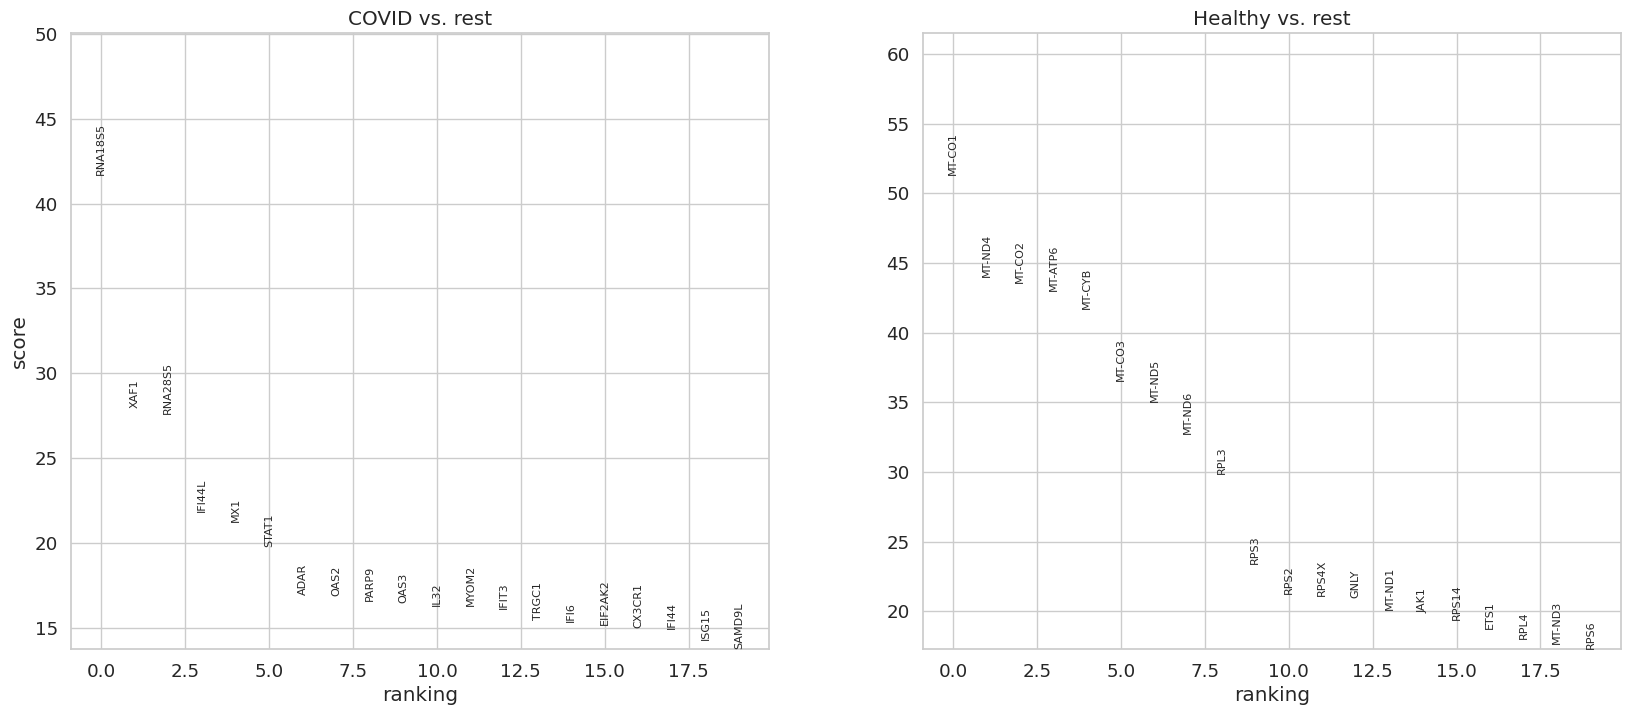

Top differentially expressed genes for COVID NK cells (adj p-value < 0.05):
      gene  logfoldchanges      pvals_adj
0  RNA18S5        0.849855   0.000000e+00
1     XAF1        1.927282  1.514694e-168
2  RNA28S5        0.608693  1.718757e-164
3   IFI44L        5.589902  3.882577e-102
4      MX1        3.659970   1.403587e-96
5    STAT1        1.727660   5.246225e-84
6     ADAR        0.897346   2.290963e-61
7     OAS2        1.815945   4.266269e-61
8    PARP9        1.913327   6.383948e-59
9     OAS3        3.704066   4.020106e-58
Top differentially expressed genes for Healthy NK cells (adj p-value < 0.05):
      gene  logfoldchanges      pvals_adj
0   MT-CO1        1.559063   0.000000e+00
1   MT-ND4        1.395890   0.000000e+00
2   MT-CO2        1.448331   0.000000e+00
3  MT-ATP6        1.334100   0.000000e+00
4   MT-CYB        1.726389   0.000000e+00
5   MT-CO3        1.354230  3.857856e-288
6   MT-ND5        1.321509  1.417063e-265
7   MT-ND6        1.488586  6.655902e-232
8     

In [3]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

# Check that the 'Status' column exists in the NK cell anndata object
assert 'Status' in nk_adata.obs.columns, "Column 'Status' not found in nk_adata.obs!"

# Explicitly ensure that only 'COVID' and 'Healthy' statuses are present
valid_status = {'COVID', 'Healthy'}
observed_status = set(nk_adata.obs['Status'].unique())
unexpected_status = observed_status - valid_status
assert len(unexpected_status) == 0, f"Unexpected Status values found: {unexpected_status}"

# Print the distribution of NK cells across COVID and Healthy groups
print('NK cell counts by Status:')
print(nk_adata.obs['Status'].value_counts())

# Perform differential expression analysis comparing COVID vs. Healthy NK cells using the Wilcoxon rank-sum test
sc.tl.rank_genes_groups(nk_adata, groupby='Status', method='wilcoxon', use_raw=False)

# Visualize the top 20 differentially expressed genes for each group
sc.pl.rank_genes_groups(nk_adata, n_genes=20, sharey=False, show=True, title='Top 20 DE Genes per Status')

# Extract and display differential expression results for each Status with filtering (e.g., adjusted p-value < 0.05)
de_results = {}
for group in nk_adata.obs['Status'].unique():
    df = pd.DataFrame({
        'gene': nk_adata.uns['rank_genes_groups']['names'][group],
        'logfoldchanges': nk_adata.uns['rank_genes_groups']['logfoldchanges'][group],
        'pvals_adj': nk_adata.uns['rank_genes_groups']['pvals_adj'][group]
    })
    # Apply a filter: adjusted p-value < 0.05
    df_filtered = df[df['pvals_adj'] < 0.05]
    de_results[group] = df_filtered
    print(f"Top differentially expressed genes for {group} NK cells (adj p-value < 0.05):")
    print(df_filtered.head(10))

# (Optional extension) Save differential expression results to CSV for further analysis
# de_results['COVID'].to_csv('covid_nk_de_results.csv', index=False)
# de_results['Healthy'].to_csv('healthy_nk_de_results.csv', index=False)

plt.show()

## Divide the NK cell subset into COVID and Healthy groups using the 'Status' metadata and check for missing values and sufficient cell numbers to ensure robust correlation calculations.

--- Correlation: percent_mt vs percent_rpl ---
COVID: Pearson correlation between percent_mt and percent_rpl: r = -0.214, p-value = 8.924e-24
Healthy: Pearson correlation between percent_mt and percent_rpl: r = -0.167, p-value = 9.018e-31

--- Correlation: percent_mt vs percent_rps ---
COVID: Pearson correlation between percent_mt and percent_rps: r = -0.217, p-value = 2.077e-24
Healthy: Pearson correlation between percent_mt and percent_rps: r = -0.165, p-value = 5.362e-30


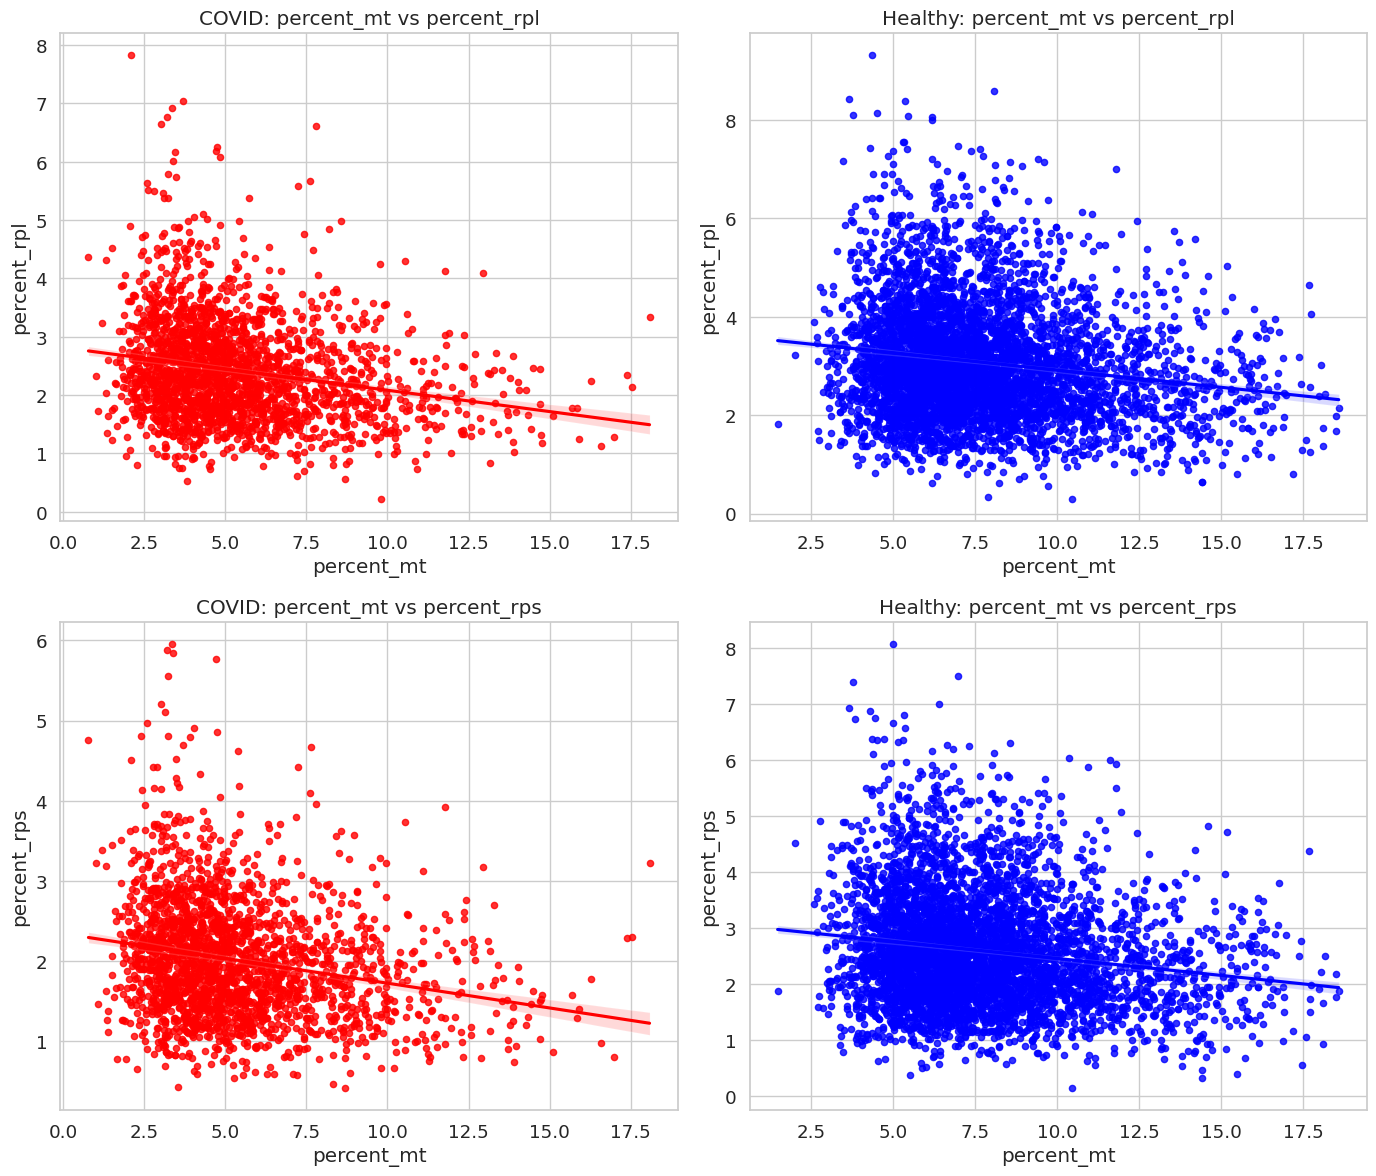


--- Fisher's z-test for percent_mt vs percent_rpl ---
z statistic = -1.891, p-value = 5.866e-02

--- Fisher's z-test for percent_mt vs percent_rps ---
z statistic = -2.097, p-value = 3.596e-02


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Split the NK cell data into COVID and Healthy groups
covid_df = nk_adata.obs[nk_adata.obs['Status'] == 'COVID'].copy()
healthy_df = nk_adata.obs[nk_adata.obs['Status'] == 'Healthy'].copy()

# Remove rows with missing values in required columns
required_cols = ['percent_mt', 'percent_rpl', 'percent_rps']
covid_df = covid_df.dropna(subset=required_cols)
healthy_df = healthy_df.dropna(subset=required_cols)

# Function to compute Pearson correlation with edge case handling

def compute_and_print_corr(df, group_name, x_col, y_col):
    # Check if there are enough data points
    if df.shape[0] < 3:
        warnings.warn(f"{group_name} group has less than 3 samples. Correlation might be unstable.")
        return np.nan, np.nan
    r, p = stats.pearsonr(df[x_col], df[y_col])
    print(f"{group_name}: Pearson correlation between {x_col} and {y_col}: r = {r:.3f}, p-value = {p:.3e}")
    return r, p

# Compute correlations for percent_mt vs percent_rpl
print("--- Correlation: percent_mt vs percent_rpl ---")
covid_r_mt_rpl, covid_p_mt_rpl = compute_and_print_corr(covid_df, 'COVID', 'percent_mt', 'percent_rpl')
healthy_r_mt_rpl, healthy_p_mt_rpl = compute_and_print_corr(healthy_df, 'Healthy', 'percent_mt', 'percent_rpl')

# Compute correlations for percent_mt vs percent_rps
print("\n--- Correlation: percent_mt vs percent_rps ---")
covid_r_mt_rps, covid_p_mt_rps = compute_and_print_corr(covid_df, 'COVID', 'percent_mt', 'percent_rps')
healthy_r_mt_rps, healthy_p_mt_rps = compute_and_print_corr(healthy_df, 'Healthy', 'percent_mt', 'percent_rps')

# Set up the figure grid for scatter plots
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Scatter and regression for percent_mt vs percent_rpl in COVID group
sns.regplot(data=covid_df, x='percent_mt', y='percent_rpl', ax=axs[0, 0], scatter_kws={'s': 20}, color='red')
axs[0, 0].set_title('COVID: percent_mt vs percent_rpl')

# Scatter and regression for percent_mt vs percent_rpl in Healthy group
sns.regplot(data=healthy_df, x='percent_mt', y='percent_rpl', ax=axs[0, 1], scatter_kws={'s': 20}, color='blue')
axs[0, 1].set_title('Healthy: percent_mt vs percent_rpl')

# Scatter and regression for percent_mt vs percent_rps in COVID group
sns.regplot(data=covid_df, x='percent_mt', y='percent_rps', ax=axs[1, 0], scatter_kws={'s': 20}, color='red')
axs[1, 0].set_title('COVID: percent_mt vs percent_rps')

# Scatter and regression for percent_mt vs percent_rps in Healthy group
sns.regplot(data=healthy_df, x='percent_mt', y='percent_rps', ax=axs[1, 1], scatter_kws={'s': 20}, color='blue')
axs[1, 1].set_title('Healthy: percent_mt vs percent_rps')

plt.tight_layout()
plt.show()

# Fisher's z transformation to compare correlation coefficients

def fishers_z(r):
    # Avoid division by zero error when r is exactly 1 or -1
    if np.abs(r) == 1:
        return np.inf
    return 0.5 * np.log((1 + r) / (1 - r))

# Ensure that sample sizes are adequate
n_covid = covid_df.shape[0]
n_healthy = healthy_df.shape[0]

if n_covid < 3 or n_healthy < 3:
    warnings.warn('One of the groups has fewer than 3 samples. Fisher\'s z-test may not be reliable.')

# For percent_mt vs percent_rpl
z_covid_mt_rpl = fishers_z(covid_r_mt_rpl)
z_healthy_mt_rpl = fishers_z(healthy_r_mt_rpl)

# Standard error for each group
se_covid = 1 / np.sqrt(n_covid - 3) if n_covid > 3 else np.inf
se_healthy = 1 / np.sqrt(n_healthy - 3) if n_healthy > 3 else np.inf

# Compute z statistic and p-value for difference
z_stat_mt_rpl = (z_covid_mt_rpl - z_healthy_mt_rpl) / np.sqrt(se_covid**2 + se_healthy**2)
p_value_mt_rpl = stats.norm.sf(abs(z_stat_mt_rpl)) * 2  # two-tailed

print("\n--- Fisher's z-test for percent_mt vs percent_rpl ---")
print(f"z statistic = {z_stat_mt_rpl:.3f}, p-value = {p_value_mt_rpl:.3e}")

# For percent_mt vs percent_rps
z_covid_mt_rps = fishers_z(covid_r_mt_rps)
z_healthy_mt_rps = fishers_z(healthy_r_mt_rps)

se_covid = 1 / np.sqrt(n_covid - 3) if n_covid > 3 else np.inf
se_healthy = 1 / np.sqrt(n_healthy - 3) if n_healthy > 3 else np.inf

z_stat_mt_rps = (z_covid_mt_rps - z_healthy_mt_rps) / np.sqrt(se_covid**2 + se_healthy**2)
p_value_mt_rps = stats.norm.sf(abs(z_stat_mt_rps)) * 2  # two-tailed

print("\n--- Fisher's z-test for percent_mt vs percent_rps ---")
print(f"z statistic = {z_stat_mt_rps:.3f}, p-value = {p_value_mt_rps:.3e}")

## Subset the NK cell anndata object into COVID-19 and Healthy groups.

In [5]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that the required columns exist in the anndata object
required_columns = ['cell_type_coarse', 'Status']
for col in required_columns:
    assert col in adata.obs.columns, f"Column '{col}' not found in adata.obs!"

# Subset to NK cells based on the 'cell_type_coarse' annotation
nk_adata = adata[adata.obs['cell_type_coarse'] == 'NK'].copy()

# Print summary information for the NK cells subset
print(f"Total NK cells: {nk_adata.n_obs}")
print(nk_adata.obs['Status'].value_counts())

# Prevent automatic rendering of large anndata representations in notebook output
None  # End of cell without returning a large object

Total NK cells: 6857
Status
Healthy    4707
COVID      2150
Name: count, dtype: int64


## Perform unsupervised sub-clustering on the NK cell subset to uncover putative NK cell subtypes.

normalizing counts per cell


    finished (0:00:00)


extracting highly variable genes


    finished (0:00:00)


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


computing PCA


    with n_comps=50


    finished (0:00:01)


computing neighbors


    using 'X_pca' with n_pcs = 20


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)


running Leiden clustering


    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


computing UMAP


    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:09)


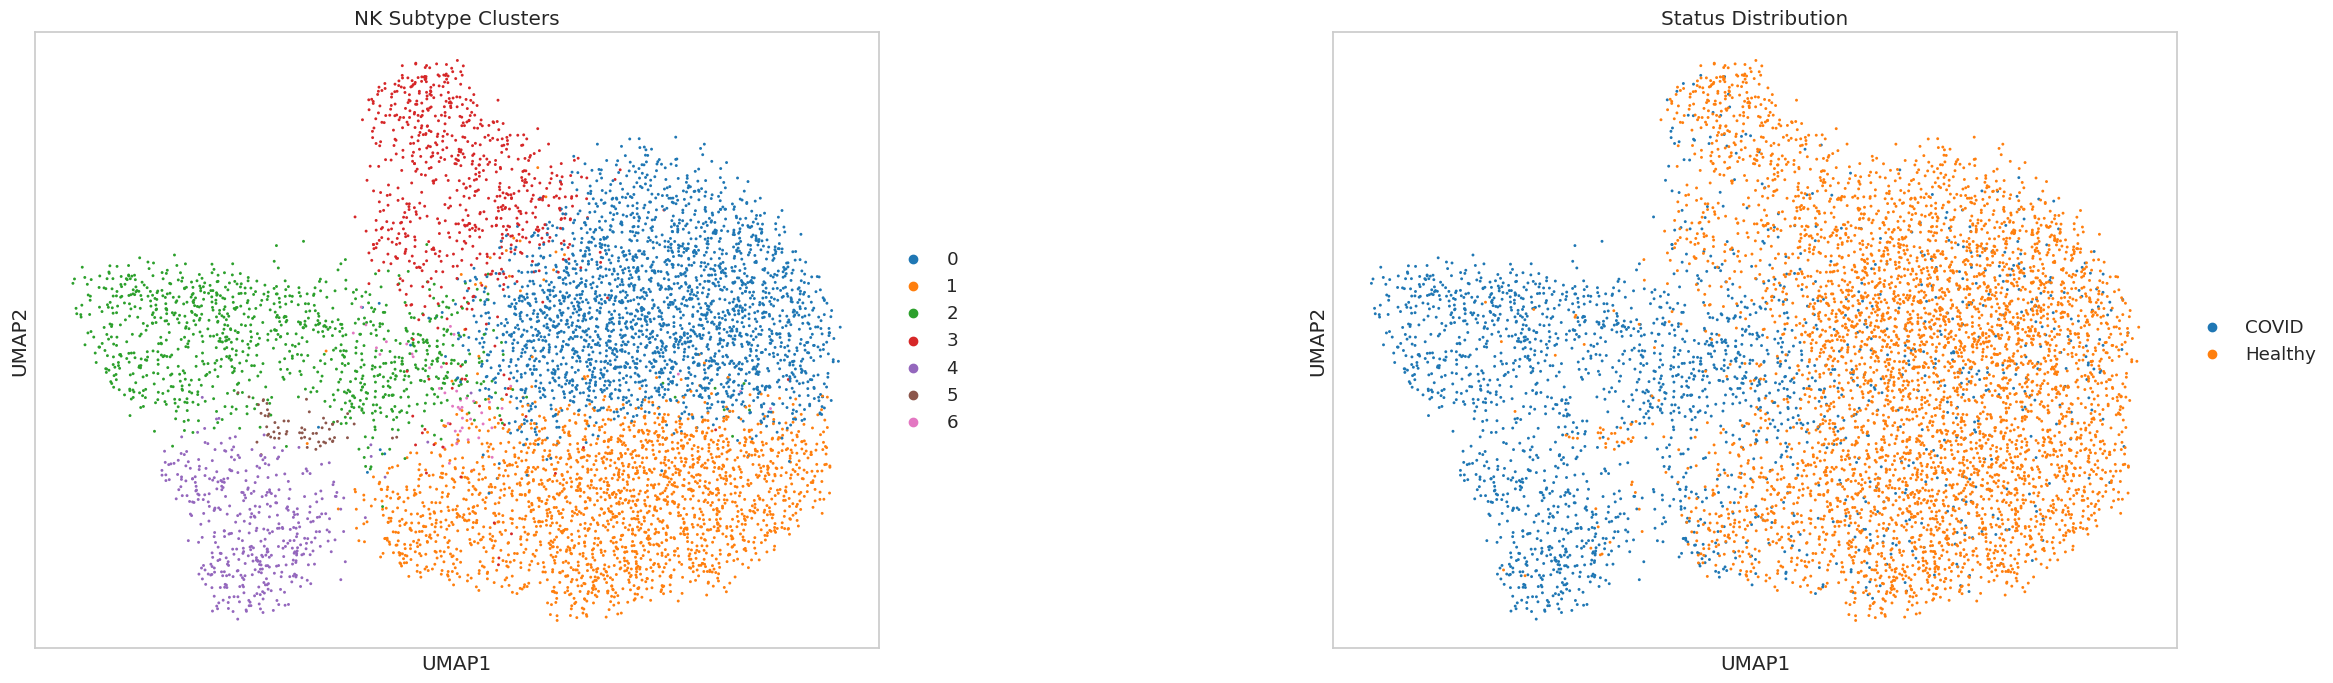

ranking genes


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:14)


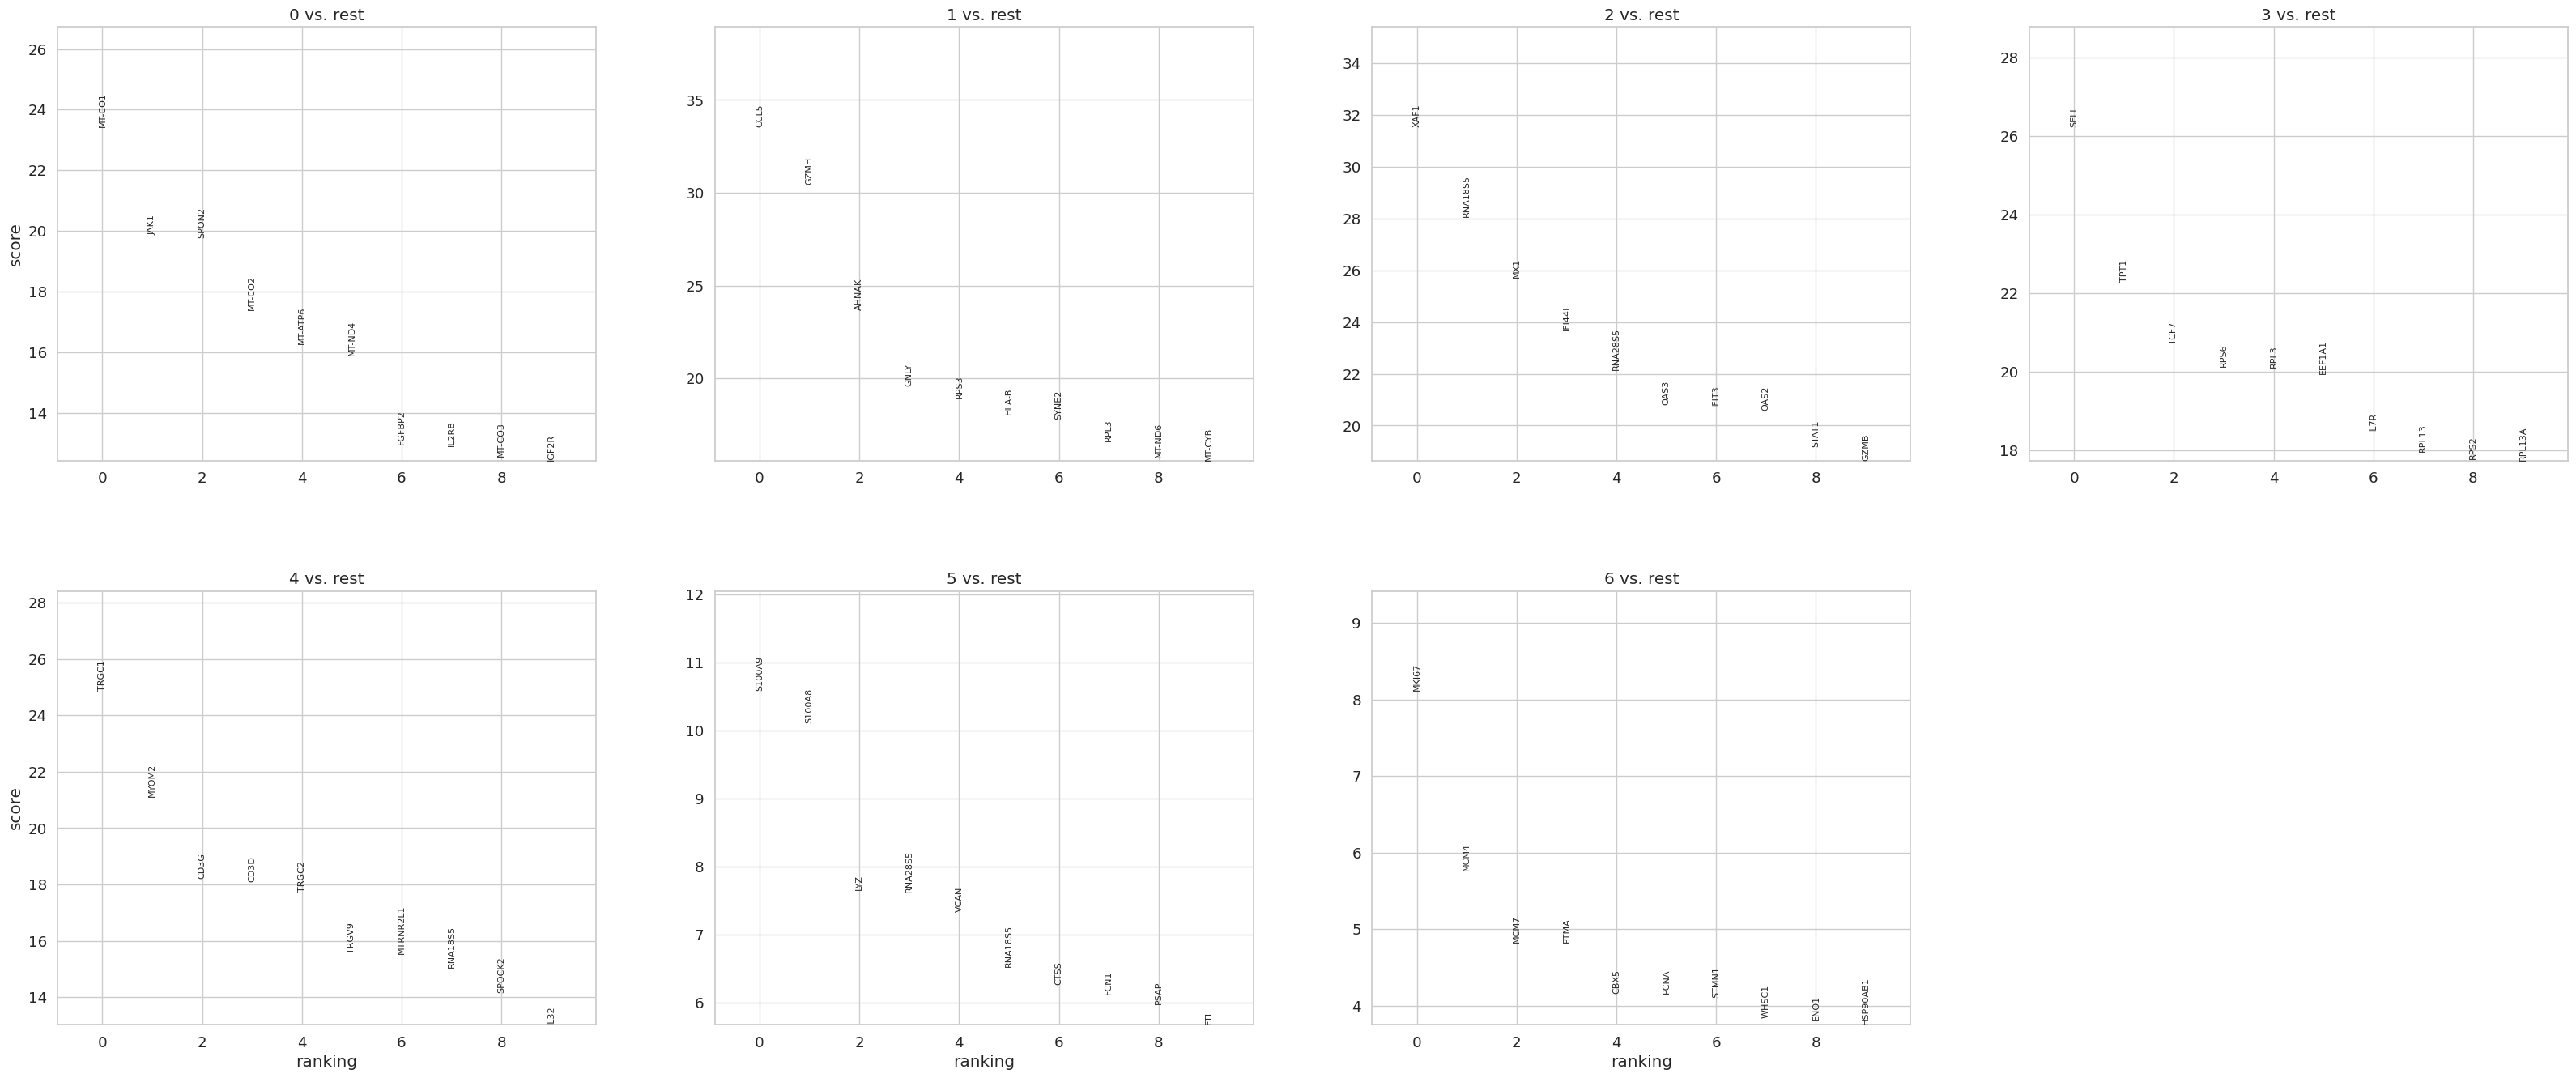

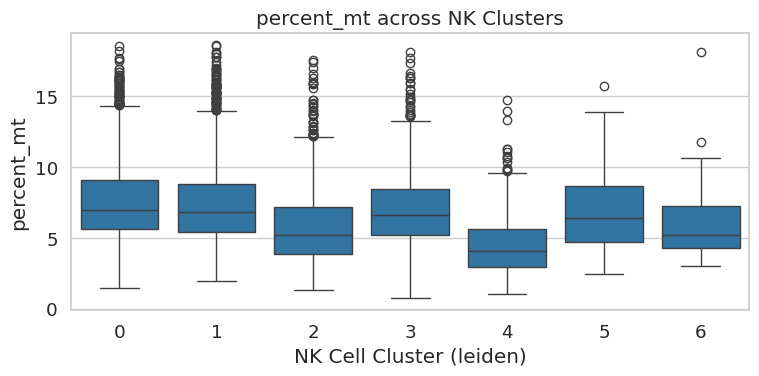

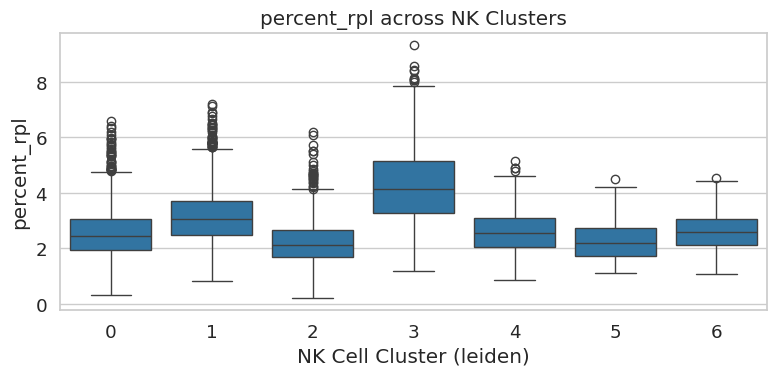

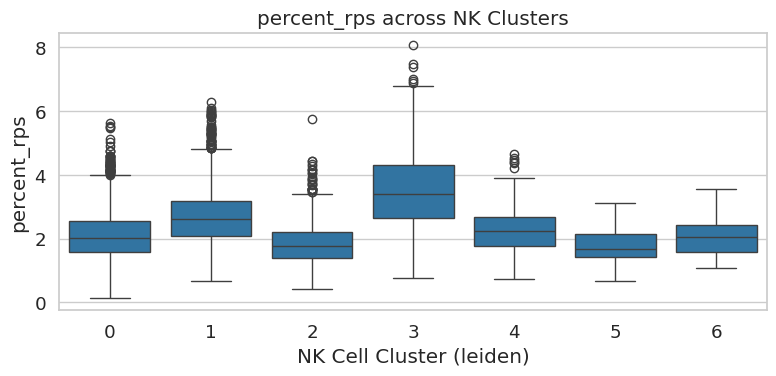

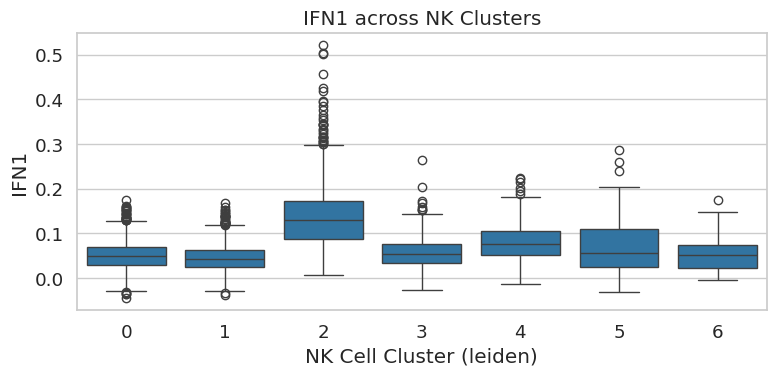

Sub-clustering of NK cells completed. Review the marker gene expression (including IFN1) to annotate putative NK subtypes and evaluate their distribution across COVID and Healthy groups.


In [6]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Use the existing NK cell anndata object (nk_adata) from previous steps and make a copy for clustering analysis
nk_adata_clust = nk_adata.copy()

# Normalize the data to a target sum of 1e4 per cell and perform log-transformation
sc.pp.normalize_total(nk_adata_clust, target_sum=1e4)  # Normalization ensures comparability across cells
sc.pp.log1p(nk_adata_clust)

# Identify the top 2000 highly variable genes; selecting these reduces noise from less informative genes
sc.pp.highly_variable_genes(nk_adata_clust, n_top_genes=2000, subset=True)

# Scale the data (capping extreme values at 10) and run PCA for dimensionality reduction
sc.pp.scale(nk_adata_clust, max_value=10)
sc.tl.pca(nk_adata_clust, svd_solver='arpack')

# Compute the neighborhood graph using 20 PCs and 10 neighbors
# Parameter choices: 20 PCs capture sufficient variance; 10 neighbors give a balance between local and global structure
sc.pp.neighbors(nk_adata_clust, n_neighbors=10, n_pcs=20)

# Perform Leiden clustering with resolution set to 0.5 for moderate cluster granularity
sc.tl.leiden(nk_adata_clust, resolution=0.5)

# Compute UMAP embedding for 2D visualization
sc.tl.umap(nk_adata_clust)

# Plot UMAP: colored by Leiden clusters and by COVID/Healthy Status
sc.pl.umap(nk_adata_clust, color=['leiden', 'Status'], wspace=0.4, title=['NK Subtype Clusters', 'Status Distribution'], show=True)

# Save the Leiden cluster labels back to the original nk_adata for continuity in downstream analyses
nk_adata.obs['leiden'] = nk_adata_clust.obs['leiden']

# Differential expression analysis among the clusters using the Wilcoxon rank-sum test
sc.tl.rank_genes_groups(nk_adata, groupby='leiden', method='wilcoxon', use_raw=False)
sc.pl.rank_genes_groups(nk_adata, n_genes=10, sharey=False, title='Top DE Genes per NK Cluster', show=True)

# Visualize expression of key features across the identified clusters using boxplots
# Including IFN1 here to directly link with the hypothesis focusing on interferon-related signatures
features = ['percent_mt', 'percent_rpl', 'percent_rps', 'IFN1']
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='leiden', y=feature, data=nk_adata.obs)
    plt.title(f'{feature} across NK Clusters')
    plt.xlabel('NK Cell Cluster (leiden)')
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

print('Sub-clustering of NK cells completed. Review the marker gene expression (including IFN1) to annotate putative NK subtypes and evaluate their distribution across COVID and Healthy groups.')


## Run differential expression analysis using the Wilcoxon rank‐sum test (if not already computed) to obtain marker genes for each NK cell cluster.

In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd

# Check if differential expression analysis (rank_genes_groups) has been computed; if not, run it
if 'rank_genes_groups' not in nk_adata.uns:
    sc.tl.rank_genes_groups(nk_adata, groupby='leiden', method='wilcoxon', use_raw=False)

# Initialize dictionary to store marker results for each cluster
all_clusters = sorted(nk_adata.obs['leiden'].unique())
marker_results = {}

# Define thresholds for selecting top markers; adjust these thresholds as needed for statistical rigor
pval_threshold = 0.05
lfc_threshold = 0.25  # example threshold for log fold-change

# Extract the top 5 marker genes per NK cell cluster using defined statistical criteria
for cluster in all_clusters:
    # Get DE results for current cluster as a DataFrame
    df = sc.get.rank_genes_groups_df(nk_adata, group=cluster)
    
    # Add comments: Selecting markers with a significant adjusted p-value and sufficient log fold-change
    # Note: Depending on the output, the column names could be 'pvals_adj' or 'pvals' and 'logfoldchanges'
    if 'pvals_adj' in df.columns:
        df_filtered = df[(df['pvals_adj'] < pval_threshold) & (df['logfoldchanges'].abs() > lfc_threshold)]
    else:
        df_filtered = df[(df['pvals'] < pval_threshold) & (df['logfoldchanges'].abs() > lfc_threshold)]
    
    # If filtering results in fewer than 5 markers, fallback to the full df
    if df_filtered.shape[0] < 5:
        df_filtered = df
    
    marker_results[cluster] = df_filtered.head(5)  # take top 5 markers based on rank
    print(f"--- Top 5 marker genes for cluster {cluster} ---")
    print(df_filtered.head(5).to_string(index=False))

# Combine marker data into one DataFrame for an overview and for downstream reproducibility
marker_table = pd.concat(marker_results, names=['Cluster', 'Row']).reset_index(level='Cluster')
print("\nCombined marker table (top 5 genes per cluster):")
print(marker_table.to_string(index=False))

# Optionally, save the marker_table for downstream analyses
# marker_table.to_csv('nk_cluster_marker_table.csv', index=False)  # Uncomment to save to file

# Generate a heatmap to visualize the expression of top marker genes across clusters
# Here, we plot the top 5 genes for each cluster using Scanpy's built-in function
sc.pl.rank_genes_groups_heatmap(nk_adata, n_genes=5, groupby='leiden', cmap='viridis', swap_axes=True, show=True)

# Additionally, plot a dotplot for a selected set of key markers (if known) to help with annotation
key_markers = []  # Populate with genes of interest if available, e.g., ['GZMB', 'NKG7']
if key_markers:
    sc.pl.dotplot(nk_adata, var_names=key_markers, groupby='leiden', standard_scale='var', title='Key NK Marker Expression', show=True)

print('Cluster annotation step completed. Review the marker gene outputs and heatmap to assign functional identities to each NK cell cluster.')